Emphasize:
- Problem Solving Skills
- Exploratory Data Analysis
- Understand Problem domain

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./data/winton/train.csv', index_col='Id')

Error function for Evaluation
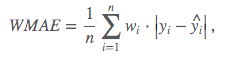

# Strategy

- [X] Data Cleaning
    - Deal with NaNs
    - Mask data
- [X 2HRS] EDA
    - Naive Model
        - Look at residuals
- [X .25HRS] Setup Cross Validating (will figure this out on Naive Model)
- [8:15] Model Improvements
    - DTW with KNN (k=1?)
        - [https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb]
        - Or possibly: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
    - Clustering
        - kmeans/GMM on features
        - Hierarchical clustering on DTW distances
    - Clustering and stacking based on membership?
    - Make a somewhat sequential model where D+2 is calculated from D+1

In [3]:
mask_exog_return_days = ['Ret_MinusTwo', 'Ret_MinusOne']
mask_endog_return_days = ['Ret_PlusOne', 'Ret_PlusTwo']

mask_exog_feature = [i for i in df.columns if 'Feature_' in i]
mask_exog_return = [i for i in df.columns 
                    if 'Ret_' in i
                    and i not in mask_exog_return_days
                    and i not in mask_endog_return_days]
mask_exog_return = [i for i in mask_exog_return if int(i.split('_')[1]) <= 120]
mask_exog = mask_exog_return + mask_exog_feature
mask_exog = mask_exog_return_days + mask_exog

mask_endog_return = [i for i in df.columns 
                    if 'Ret_' in i
                    and i not in mask_exog_return_days
                    and i not in mask_endog_return_days]
mask_endog_return = [i for i in mask_endog_return if int(i.split('_')[1]) > 120]
mask_endog = mask_endog_return + mask_endog_return_days

mask_weights = ['Weight_Intraday', 'Weight_Daily']

### Data Cleaning

In [133]:
df.dtypes

Feature_1          float64
Feature_2          float64
Feature_3          float64
Feature_4          float64
Feature_5          float64
Feature_6          float64
Feature_7            int64
Feature_8          float64
Feature_9          float64
Feature_10         float64
Feature_11         float64
Feature_12         float64
Feature_13         float64
Feature_14         float64
Feature_15         float64
Feature_16         float64
Feature_17         float64
Feature_18         float64
Feature_19         float64
Feature_20         float64
Feature_21         float64
Feature_22         float64
Feature_23         float64
Feature_24         float64
Feature_25         float64
Ret_MinusTwo       float64
Ret_MinusOne       float64
Ret_2              float64
Ret_3              float64
Ret_4              float64
                    ...   
Ret_155            float64
Ret_156            float64
Ret_157            float64
Ret_158            float64
Ret_159            float64
Ret_160            float64
R

Not sure what 'Feature_7' is. Maybe it's a population? Will keep this in mind throughout. 

In [134]:
df['Feature_7']

Id
1        75751
2        17369
3         8277
4        22508
5        22423
6        24099
7        39351
8        92214
9        18418
10       47637
11       51499
12       79888
13       63267
14       35023
15       76131
16       69564
17       94022
18       16080
19       14259
20       65146
21       47683
22       35266
23       49660
24       57773
25       34161
26       64351
27       19660
28       94975
29       99483
30       40712
         ...  
39971    54939
39972    76736
39973    62179
39974    39562
39975    34124
39976    60280
39977    99075
39978    48365
39979    39069
39980    23153
39981    44670
39982    34324
39983    39848
39984     1344
39985    29262
39986    97667
39987    34425
39988    27661
39989    43321
39990    33304
39991    62488
39992    28859
39993    82639
39994    35409
39995    64603
39996    23729
39997    56222
39998     7024
39999    27376
40000     4141
Name: Feature_7, Length: 40000, dtype: int64

### Deal with NaNs

##### Most rows have nulls

In [4]:
df.isnull().values.any(axis=1).mean()

0.976775

In [5]:
mask_ignore_feat = list(filter(lambda x: 'Feat' not in x, mask_exog))

##### Half of the rows that have a null 'anywhere' are due to features missing. Let's ignore them for the naive model. (for now)

In [6]:
df[mask_ignore_feat]\
    .isnull().values.any(axis=1).mean()

0.44025

##### non of the endog return days are missing this is nice. 

In [7]:
df[mask_endog_return_days].isnull().values.any(axis=1).mean()

0.0

##### None of the endog minutes are missing

In [8]:
df[mask_endog].isnull().values.any(axis=1).mean()

0.0

##### none of the exogenous days are missing (D-2 and D-1)

In [9]:
df[mask_exog_return_days].isnull().mean()

Ret_MinusTwo    0.0
Ret_MinusOne    0.0
dtype: float64

#### For the missing exogenous minute time data how do we want to handle NaNs?

For exogenous minutes it looks like there's never more than 3.5% of the data missing. Since this is a pretty small I will fillna's with linearly interpolated data. I can come back to this later. 

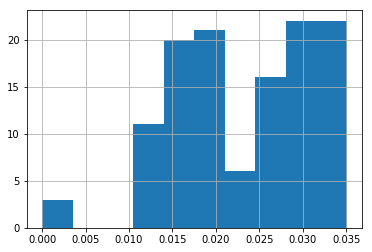

In [10]:
df[mask_ignore_feat].isnull().mean().hist()

##### Interpolate missing exogenous minutes

In [11]:
def interpolate_time(df):
    df[mask_ignore_feat] = df[mask_ignore_feat].T.interpolate().T
    return df

#### Before and after interpolation

In [12]:
df[mask_ignore_feat].isnull().values.any(axis=1).mean()

0.44025

##### 0 nulls are left

In [13]:
df = interpolate_time(df)

In [14]:
df[mask_ignore_feat].isnull().values.any(axis=1).mean()

0.0

#### Apply mask

In [15]:
X = df[mask_exog]
Y = df[mask_endog]
w = df[mask_weights]

done  (for now)

### Naive Model
- Residuals
- Other artifacts observations? 

Keeping things really simple.

I'm going to simply start by predicting the average return for T-121 -- 180 and then also the return for D + 1 and D + 2. 

Since there are a lot of NaN's I'm going to 

In [16]:
X['intra_return_mean'] = X[mask_exog_return].T.mean()
X['intra_return_std'] = X[mask_exog_return].T.std()
X['intra_return_max'] = X[mask_exog_return].T.max()
X['intra_return_min'] = X[mask_exog_return].T.min()

Y['intra_return_mean'] = Y[mask_endog_return].T.mean()

/Users/ryan/miniconda3/envs/time_series/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ryan/miniconda3/envs/time_series/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ryan/miniconda3/envs/time_series/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [90]:
mask_x_simple = ["intra_return_mean", "intra_return_std", "intra_return_max", "intra_return_min"]

Y_simple = Y[['intra_return_mean'] + mask_endog_return_days]
X_simple = X[mask_x_simple + mask_exog_return_days]

Apply the sample weights in training. 

For the intra_return_mean I'm going to use the weights times 60 for intra_return_mean since it's the mean of 60 intra day returns

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RANSACRegressor

cv = KFold(n_splits=5, shuffle=True, random_state=42)

model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('LinearReg', RANSACRegressor())])

##### Getting a sense of training time

In [21]:
%%timeit
limit = 1000
model.fit(X_simple.iloc[:limit],
          Y_simple.iloc[:limit])

56.1 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
limit = 2000
model.fit(X_simple.iloc[:limit],
          Y_simple.iloc[:limit])

63.4 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit
limit = 4000
model.fit(X_simple.iloc[:limit],
          Y_simple.iloc[:limit])

96.1 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### MAE

In [240]:
def WMAE(y_true, y_pred, weights=None):
    if weights is None:
        # don't apply weights
        return np.mean(np.abs(y_true - y_pred))
    # do apply weights
    return np.mean(np.abs(y_true - y_pred) * weights)

w_1 weights have the intraday multiplied by 60 since we reduced from 60 features down to one aggregate feature that captures information about . Since the weight would have been applied to each of the intraday dependent variables (T-121 to T-180) it is appropriate to multiply 

In [286]:
w_1 = pd.concat([w['Weight_Intraday'] * 60, w['Weight_Daily'], w['Weight_Daily']], axis=1)

### Build and score model
- Implicit Assumptions (not necessarily intended)
    - T-120 to T-180, Day + 1, Day + 2 are independent of one another. (obv not the case) 
    - Basic out of the box RANSAC Model with no hyper parameter tuning

In [300]:
model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('RANSAC', RANSACRegressor())])

model.fit(X_simple, Y_simple)

y_pred = model.predict(X_simple)

WMAE(Y_simple.values, y_pred, weights=w_1.values)

29459.090981158544

### Setup Cross Validation (with naive model)

In [285]:
from sklearn.model_selection import KFold

cv = KFold(3, shuffle=True, random_state=42)

cross_val_mae = []
for train, val in cv.split(X_simple, Y_simple):
    model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                              ('RANSAC', RANSACRegressor())])
    model.fit(X_simple.iloc[train],
              Y_simple.iloc[train])
    y_pred = model.predict(X_simple.iloc[val])
    cross_val_mae.append(WMAE(Y_simple.iloc[val].values, y_pred, w_1.iloc[val].values))

print('Cross Val Score: {}\n Cross Val Std: {}'.format(np.mean(cross_val_mae), np.std(cross_val_mae)))

Cross Val Score: 26808.539474113237
 Cross Val Std: 2747.6092437197067


### Evaluate Residuals

In [155]:
def resid_plot(y_pred, y_actual, title):
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(y_pred, y_pred - y_actual)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Predicted - Actual')
    plt.title(title + " Residuals", fontsize=10)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.hist(y_pred - y_actual, orientation='horizontal', bins=15)
    plt.title(title + " Hist of Residuals", fontsize=10)
#     plt.savefig('/Users/ryanlambert/Desktop/' + title + "_Hist_of_Residuals.png")
    plt.show()
    plt.hexbin(y_pred, y_pred - y_actual, gridsize=20)
    plt.title(title + " Hexbin of Residuals", fontsize=10)

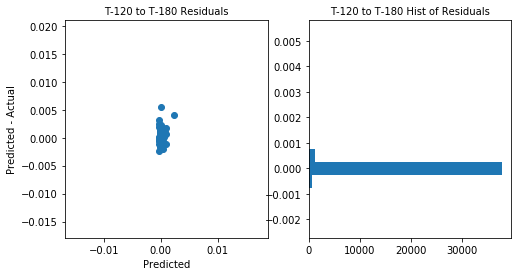

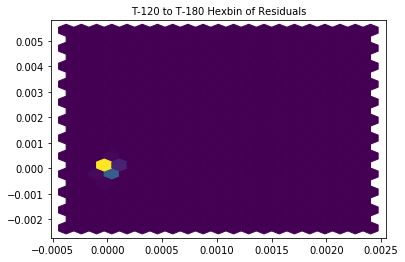

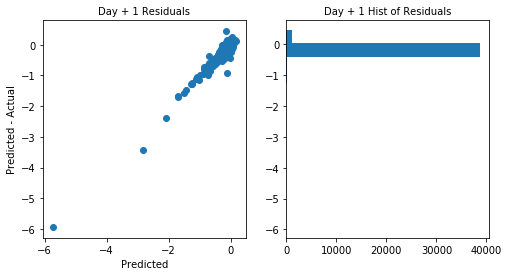

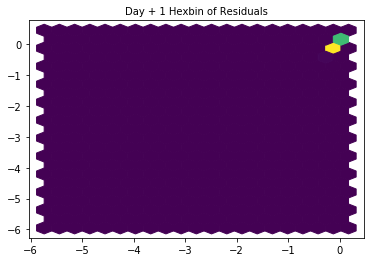

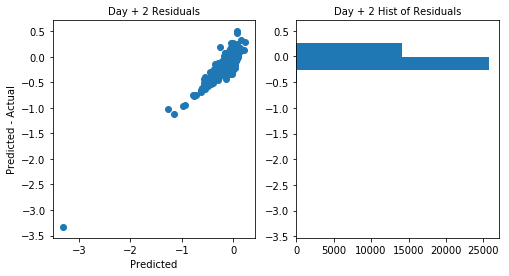

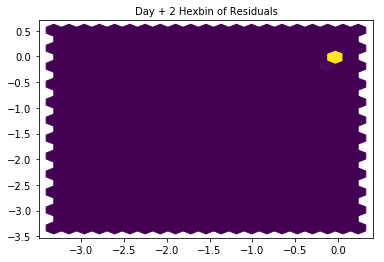

In [252]:
for col, title in enumerate(['T-120 to T-180', 'Day + 1', 'Day + 2']):
    resid_plot(y_pred[:, col], Y_simple.iloc[:, col], title)

### Build and score model
- Implicit Assumptions (not necessarily intended)
    - T-120 to T-180, Day + 1, Day + 2 are independent of one another. (obv not the case) 
    - Basic out of the box RANSAC Model with no hyper parameter tuning

In [290]:
model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('RANSAC', RANSACRegressor())])

model.fit(X_simple, Y_simple)

y_pred = model.predict(X_simple)

WMAE(Y_simple.values, y_pred, weights=w_1.values)

36026.14802078365

This first model is only using the time itself. 

What happens when I include the features? 

### Include the other predictors

In [295]:
X_simple_w_feat()

,intra_return_mean,intra_return_std,intra_return_max,intra_return_min,Ret_MinusTwo,Ret_MinusOne
Id,,,,,,
1,-2.309491e-04,0.000785,0.001279,-0.003579,0.055275,-0.010770
2,-6.841641e-05,0.000364,0.000753,-0.001000,0.009748,0.002987
3,-5.315209e-06,0.000525,0.001702,-0.001177,0.003077,0.006181
4,1.345552e-05,0.000290,0.000711,-0.000710,0.000984,0.014106
5,-1.927014e-05,0.000832,0.002431,-0.002428,-0.018224,0.011065
6,1.446511e-04,0.000777,0.002801,-0.002751,0.014473,0.007139
7,4.992629e-05,0.000258,0.000719,-0.000575,-0.002893,0.006601
8,-2.472475e-05,0.000432,0.001236,-0.001504,0.004587,0.006156
9,3.107463e-05,0.000477,0.001281,-0.001681,0.002507,-0.015937


### Build and score model
- Add the features with prefix `Feature_`
- *Implicit* assumptions
    - Features are all independent

In [399]:
mask_simple_w_features = list(X_simple.columns) + mask_exog_feature

In [400]:
X_wfeatures = X[mask_simple_w_features]

##### For time's sake I'm not going to bother including features that are mostly nulls

Text(0,0.5,'Percentage Nulls')

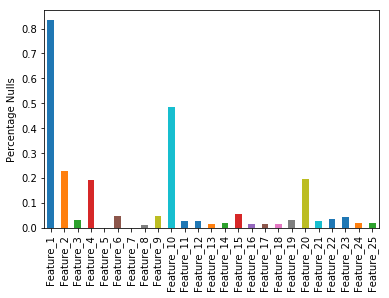

In [391]:
X_wfeatures[['Feature_{}'.format(i) for i in range(1, 26)]].isnull().mean().plot(kind='bar')
plt.ylabel('Percentage Nulls')

Let's see how we do using only features that are significantly less than 10% nulls. (just to keep things simple)

In [405]:
X_wfeatures = X_wfeatures.drop(['Feature_1', 'Feature_2', 'Feature_4',
                                'Feature_10', 'Feature_20'], axis=1)

In [408]:
X_wfeatures.isnull().values.any(axis=1)

array([ True,  True,  True, ..., False,  True,  True])

In [389]:
model = Pipeline(steps = [('minmax_scaler', MinMaxScaler()),
                          ('RANSAC', RANSACRegressor())])

model.fit(X_wfeatures, Y_simple)

y_pred = model.predict(X_wfeatures)

WMAE(Y_simple.values, y_pred, weights=w_1.values)

ValueError: Found input variables with inconsistent numbers of samples: [25027, 40000]

In [385]:
X_wfeatures

,intra_return_mean,intra_return_std,intra_return_max,intra_return_min,Ret_MinusTwo,Ret_MinusOne,Feature_5,Feature_7
Id,,,,,,,,
1,-2.309491e-04,0.000785,0.001279,-0.003579,0.055275,-0.010770,8.0,75751
2,-6.841641e-05,0.000364,0.000753,-0.001000,0.009748,0.002987,3.0,17369
3,-5.315209e-06,0.000525,0.001702,-0.001177,0.003077,0.006181,9.0,8277
4,1.345552e-05,0.000290,0.000711,-0.000710,0.000984,0.014106,5.0,22508
5,-1.927014e-05,0.000832,0.002431,-0.002428,-0.018224,0.011065,7.0,22423
6,1.446511e-04,0.000777,0.002801,-0.002751,0.014473,0.007139,1.0,24099
7,4.992629e-05,0.000258,0.000719,-0.000575,-0.002893,0.006601,7.0,39351
8,-2.472475e-05,0.000432,0.001236,-0.001504,0.004587,0.006156,8.0,92214
9,3.107463e-05,0.000477,0.001281,-0.001681,0.002507,-0.015937,8.0,18418


### DTW and KNN
inspiration from: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html


The thinking here is that I can use the 

### Sequence

Right now the ~2+ day window of exogenous variables predicting the next ~2+ days of returns has an underlying assumption that Times T121 - T180, D + 1, and D + 2 are all independent of one another. 

Being a time series problem. Let's look at modeling 

### Lomb Scargle? 